# Import Libraries

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


# Data Processing

In [24]:
train_df = pd.read_csv("../../data/train_data_v3.csv")
validate_df = pd.read_csv("../../data/validate_data_v3.csv")
test_df = pd.read_csv("../../data/test_data_v3.csv")

In [25]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(8000, 42)
(1000, 42)
(1000, 42)


### Process datetime column

In [26]:
def encode_timestamp(df):
    df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'], errors='coerce')

    # Extract features
    df['Weather_Year'] = df['Weather_Timestamp'].dt.year
    df['Weather_Month'] = df['Weather_Timestamp'].dt.month
    df['Weather_Day'] = df['Weather_Timestamp'].dt.day
    df['Weather_Hour'] = df['Weather_Timestamp'].dt.hour
    df['Weather_Day_of_Week'] = df['Weather_Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
    df['Weather_Is_Weekend'] = df['Weather_Day_of_Week'].isin([5, 6]).astype(int)

    df.drop(columns=['Weather_Timestamp'], inplace=True)
    return df

In [27]:
train_df = encode_timestamp(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,10.0,CALM,...,0,0,0,1,2022,8,3,5,2,0
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,20.0,W,...,0,0,0,1,2020,6,3,14,2,0
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,10.0,VAR,...,0,0,0,1,2022,8,11,9,3,0
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,10.0,CALM,...,0,0,0,1,2022,7,25,7,0,0
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,10.0,SW,...,0,0,0,1,2020,5,20,15,2,0


In [28]:
validate_df = encode_timestamp(validate_df)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-6440727,1376,0.013,Incident on E HOLT BLVD near CORONA AVE Drive ...,91761-2110,46.0,83.0,29.02,10.0,CALM,...,0,0,0,2,2021,1,29,20,4,0
1,A-3749509,1152,0.086,Incident on BISCAYNE BAY DR near HOUSE 12700 D...,33181,79.0,62.0,30.05,10.0,NE,...,0,0,0,2,2022,12,5,16,0,0
2,A-7118981,928,0.700,At MD-5/Branch Ave/Exit 7 - Accident.,20748,60.0,55.0,29.80,10.0,W,...,0,0,0,3,2020,3,17,14,1,0
3,A-2308799,327,0.000,Accident on I-94 Westbound at Exit 208 Schaefe...,48120,18.0,84.0,31.08,1.2,East,...,0,1,0,3,2019,2,27,4,2,0
4,A-5403565,656,0.386,Crash blocking the left lane on SR-260 Westbou...,85541,72.0,69.0,25.02,10.0,CALM,...,0,0,0,2,2022,7,30,9,5,1


In [29]:
test_df = encode_timestamp(test_df)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 47)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Weather_Condition_Others,Weather_Condition_Snow,Weather_Condition_Thunderstorms / Severe Weather,Severity,Weather_Year,Weather_Month,Weather_Day,Weather_Hour,Weather_Day_of_Week,Weather_Is_Weekend
0,A-924015,484,0.000,Lane blocked due to accident on OR-238 Westbou...,97530,54.0,66.0,28.71,8.0,CALM,...,0,0,0,2,2021,8,26,6,3,0
1,A-1744687,556,0.000,Accident on CR-266 John St both ways at Perkin...,14623-2417,40.0,93.0,29.73,7.0,CALM,...,0,0,0,2,2019,10,10,7,3,0
2,A-5488029,1109,0.711,Slow traffic on I-20 W from SC-215/Monticello ...,29210,82.0,69.0,29.62,10.0,SW,...,0,0,0,2,2021,6,22,17,1,0
3,A-3844411,974,0.141,NYSDOT - Region 8: Crash on Taconic State Park...,12037,32.0,96.0,28.60,3.0,CALM,...,0,1,0,2,2023,1,19,14,3,0
4,A-1353192,616,0.000,Accident on Illinois Ave at 48th Ave.,37209-3441,68.0,81.0,29.56,10.0,E,...,0,0,0,2,2020,10,22,8,3,0


### Process categorical columns

In [30]:
for name, df in zip(['train_df', 'validate_df', 'test_df'], [train_df, validate_df, test_df]):
    print(f"--- {name} ---")
    for col in ['Wind_Direction', 'Description', 'Zipcode']:
        unique_values = df[col].unique()
        value_counts = df[col].value_counts()

        print(f"\nColumn: {col}")
        print(f"Unique values ({len(unique_values)}): {unique_values}")
        print("Value counts:")
        print(value_counts)
        print("-" * 40)
    print("\n" + "=" * 60 + "\n")



--- train_df ---

Column: Wind_Direction
Unique values (23): ['CALM' 'W' 'VAR' 'SW' 'SE' 'S' 'WSW' 'E' 'NE' 'N' 'NNW' 'SSW' 'NNE' 'NW'
 'ESE' 'ENE' 'SSE' 'WNW' 'North' 'West' 'South' 'Variable' 'East']
Value counts:
Wind_Direction
CALM        1301
S            641
W            553
SSW          457
N            427
SW           420
WNW          416
SSE          383
WSW          382
VAR          378
NW           372
E            363
NNW          334
SE           326
NNE          294
ESE          274
ENE          273
NE           245
East          43
South         39
North         37
West          26
Variable      16
Name: count, dtype: int64
----------------------------------------

Column: Description
Unique values (7823): ['Crash on Hard Scrabble Rd at Clemson Rd.'
 'At OH-87/S Woodland Rd - Accident.'
 'Crash on Rosewood Ave at Nansemond St.' ...
 'At Pleasant Hill Rd - Accident.'
 'Closed at US-220-BR/VA-457/Memorial Blvd - Road closed due to accident.'
 'Closed between CR-19/S Cente

In [31]:
def encode_categorical(df, reference_columns=None):
    # One-hot encode 'Wind_Direction'
    df = pd.get_dummies(df, columns=['Wind_Direction'], drop_first=True)

    # Convert True/False to 0/1 after encoding
    for col in df.select_dtypes(include=['bool']).columns:
        df[col] = df[col].astype(int)

    # Ensure consistent columns for validate/test DataFrame
    if reference_columns is not None:
        missing_cols = [col for col in reference_columns if col not in df.columns]
        for col in missing_cols:
            df[col] = 0  # Add missing columns with 0s
        df = df[reference_columns]

    return df

In [32]:
train_df = encode_categorical(train_df)
print(f"train_df shape: {train_df.shape}")
train_df.head()

train_df shape: (8000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-547872,372,0.0,Crash on Hard Scrabble Rd at Clemson Rd.,29223-8559,77.0,88.0,29.81,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-6997925,922,0.0,At OH-87/S Woodland Rd - Accident.,44022,75.0,65.0,28.84,20.0,17.0,...,0,0,0,0,0,0,1,0,0,0
2,A-539957,649,0.0,Crash on Rosewood Ave at Nansemond St.,23221-3430,79.0,84.0,29.80,10.0,3.0,...,0,0,0,0,1,0,0,0,0,0
3,A-556754,544,0.0,Crash on Gellhorn Dr at Loop Fwy.,77029,82.0,79.0,29.98,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,A-7040745,993,0.0,At CR-676A/Bloomingdale Av/Progress BL - Accid...,33578,86.0,55.0,29.91,10.0,7.0,...,0,0,1,0,0,0,0,0,0,0


In [33]:
validate_df = encode_categorical(validate_df, reference_columns=train_df.columns)
print(f"validate_df shape: {validate_df.shape}")
validate_df.head()

validate_df shape: (1000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-6440727,1376,0.013,Incident on E HOLT BLVD near CORONA AVE Drive ...,91761-2110,46.0,83.0,29.02,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-3749509,1152,0.086,Incident on BISCAYNE BAY DR near HOUSE 12700 D...,33181,79.0,62.0,30.05,10.0,9.0,...,0,0,0,0,0,0,0,0,0,0
2,A-7118981,928,0.700,At MD-5/Branch Ave/Exit 7 - Accident.,20748,60.0,55.0,29.80,10.0,13.0,...,0,0,0,0,0,0,1,0,0,0
3,A-2308799,327,0.000,Accident on I-94 Westbound at Exit 208 Schaefe...,48120,18.0,84.0,31.08,1.2,10.4,...,0,0,0,0,0,0,0,0,0,0
4,A-5403565,656,0.386,Crash blocking the left lane on SR-260 Westbou...,85541,72.0,69.0,25.02,10.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
test_df = encode_categorical(test_df, reference_columns=train_df.columns)
print(f"test_df shape: {test_df.shape}")
test_df.head()

test_df shape: (1000, 68)


,ID,End_Time,Distance(mi),Description,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West
0,A-924015,484,0.000,Lane blocked due to accident on OR-238 Westbou...,97530,54.0,66.0,28.71,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,A-1744687,556,0.000,Accident on CR-266 John St both ways at Perkin...,14623-2417,40.0,93.0,29.73,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,A-5488029,1109,0.711,Slow traffic on I-20 W from SC-215/Monticello ...,29210,82.0,69.0,29.62,10.0,9.0,...,0,0,1,0,0,0,0,0,0,0
3,A-3844411,974,0.141,NYSDOT - Region 8: Crash on Taconic State Park...,12037,32.0,96.0,28.60,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,A-1353192,616,0.000,Accident on Illinois Ave at 48th Ave.,37209-3441,68.0,81.0,29.56,10.0,3.0,...,0,0,0,0,0,0,0,0,0,0


### Drop irrelevant columns

In [35]:
irrelevant_columns = ["ID", "Description", "Zipcode"]
train_df = train_df.drop(columns=irrelevant_columns, errors='ignore')
validate_df = validate_df.drop(columns=irrelevant_columns, errors='ignore')
test_df = test_df.drop(columns=irrelevant_columns, errors='ignore')

# Evaluation Function

In [36]:
def evaluate(y_pred, y_test, X_test, model):
    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Compute AUC-ROC curve
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])
    y_pred_prob = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Define Features & Target

In [37]:
# Define features and target
X_train = train_df.drop(columns=["Severity"])
y_train = train_df["Severity"]

X_validate = validate_df.drop(columns=["Severity"])
y_validate = validate_df["Severity"]

X_test = test_df.drop(columns=["Severity"])
y_test = test_df["Severity"]


# Baseline Model

In [38]:

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_validate)

Accuracy: 0.514
F1 Score: 0.5871976665969246
Classification Report:
               precision    recall  f1-score   support

           1       0.21      1.00      0.34        14
           2       0.97      0.46      0.63       828
           3       0.35      0.75      0.47       124
           4       0.09      0.71      0.16        34

    accuracy                           0.51      1000
   macro avg       0.40      0.73      0.40      1000
weighted avg       0.85      0.51      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 43 383 171 231]
 [ 10   8  93  13]
 [  1   5   4  24]]


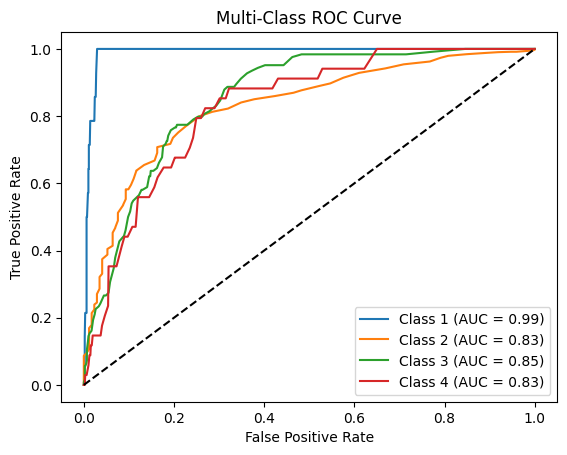

In [39]:
evaluate(y_pred, y_validate, X_validate, model)


Accuracy: 0.522
F1 Score: 0.6153477705420437
Classification Report:
               precision    recall  f1-score   support

           1       0.10      1.00      0.19         6
           2       0.97      0.49      0.65       857
           3       0.33      0.69      0.45       119
           4       0.05      0.72      0.09        18

    accuracy                           0.52      1000
   macro avg       0.36      0.73      0.35      1000
weighted avg       0.87      0.52      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 37 421 161 238]
 [ 14  11  82  12]
 [  1   2   2  13]]


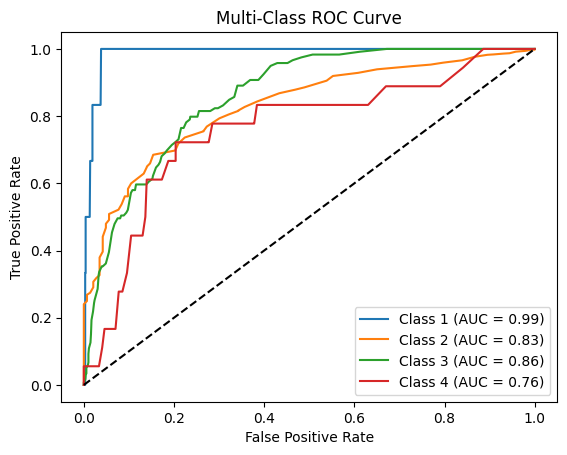

In [40]:
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, X_test, model)


# Backward Selection

Accuracy: 0.528
F1 Score: 0.5979522154631781
Classification Report:
               precision    recall  f1-score   support

           1       0.22      1.00      0.36        14
           2       0.98      0.47      0.64       828
           3       0.35      0.77      0.48       124
           4       0.11      0.82      0.19        34

    accuracy                           0.53      1000
   macro avg       0.41      0.77      0.42      1000
weighted avg       0.86      0.53      0.60      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 41 391 173 223]
 [  8   7  95  14]
 [  0   3   3  28]]


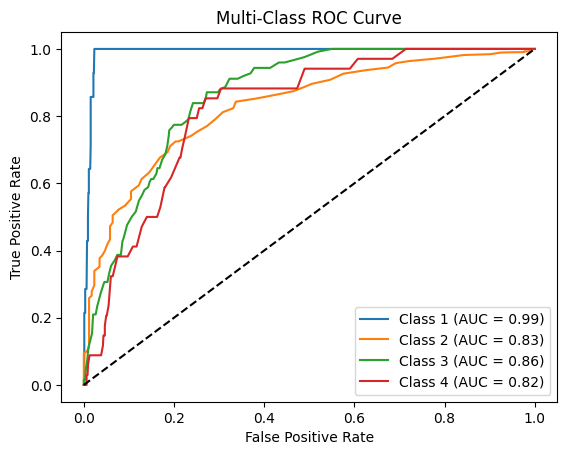

Accuracy: 0.525
F1 Score: 0.6162856684377307
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.19         6
           2       0.97      0.49      0.65       857
           3       0.33      0.71      0.45       119
           4       0.05      0.67      0.09        18

    accuracy                           0.53      1000
   macro avg       0.36      0.72      0.35      1000
weighted avg       0.87      0.53      0.62      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 36 422 174 225]
 [ 13   9  85  12]
 [  1   3   2  12]]


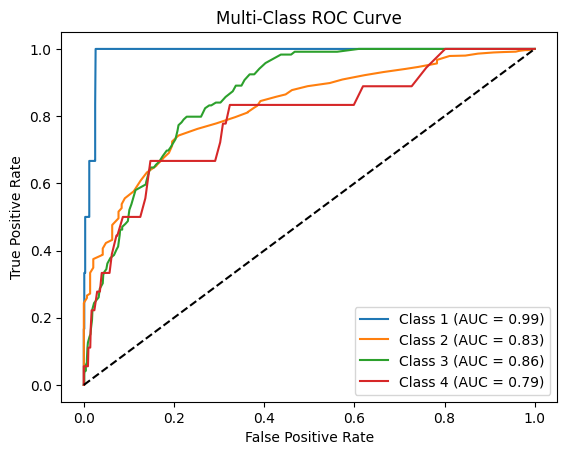

In [41]:

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Perform Recursive Feature Elimination (RFE)
selector = RFE(model, step=1)  # Adjust step for faster elimination if needed
selector.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[selector.support_]

# Transform both training and validation datasets
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)  # Apply to test set as well

# Train a new Random Forest model on the reduced feature set
model.fit(X_train_selected, y_train)

# Make predictions
y_pred_validate = model.predict(X_validate_selected)

# Evaluate the model
evaluate(y_pred_validate, y_validate, X_validate_selected, model)

# Make predictions on the test set
y_pred_test = model.predict(X_test_selected)
evaluate(y_pred_test, y_test, X_test_selected, model)


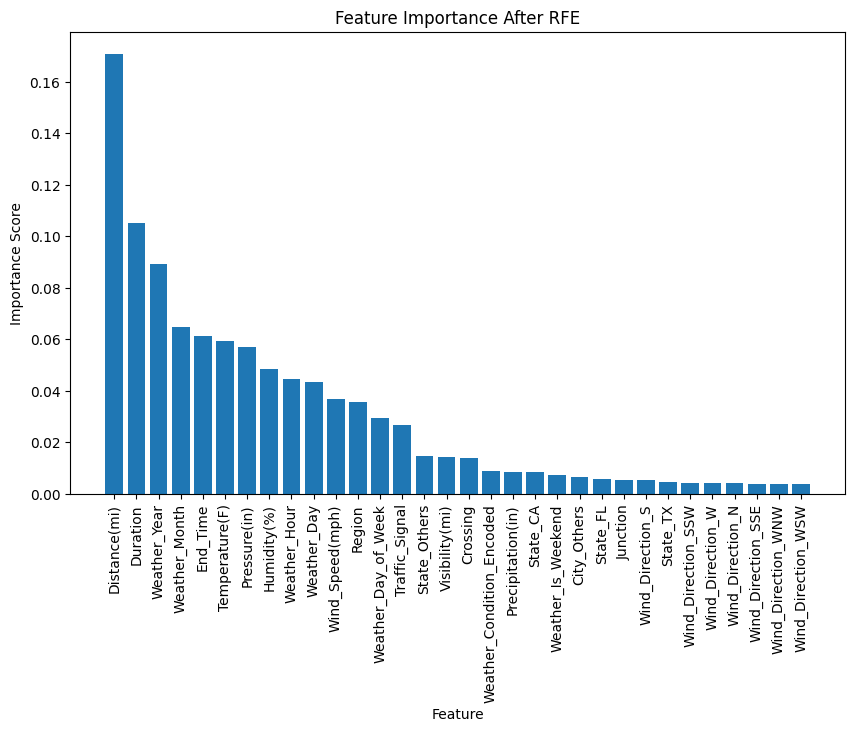

In [42]:
import numpy as np

# Extract feature importance
feature_importance = model.feature_importances_

# Sort feature importance for better visualization
indices = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance After RFE")
plt.bar(range(len(selected_features)), feature_importance[indices], align="center")
plt.xticks(range(len(selected_features)), np.array(selected_features)[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()


# Parameter Tuning

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END ccp_alpha=0.0, max_depth=None, max_samples=None, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END ccp_

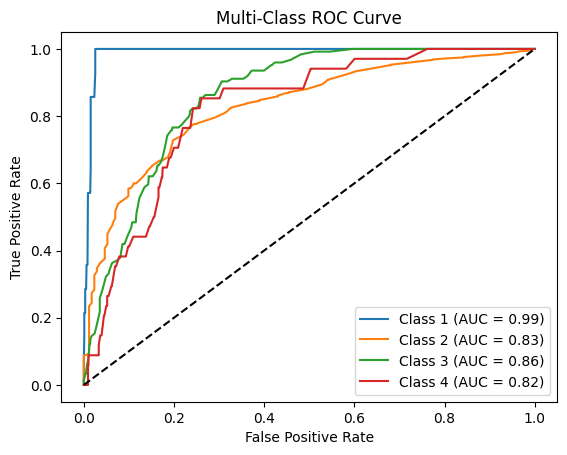

In [43]:
# Perform Recursive Feature Elimination (RFE)
selector = RFE(RandomForestClassifier(random_state=42), step=1)
selector.fit(X_train, y_train)

# Select only important features
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'ccp_alpha': [0.0, 0.01, 0.1],  
    'max_samples': [None, 0.5, 0.8]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the **selected feature** training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model.predict(X_validate_selected)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)



Best parameters found:  {'ccp_alpha': 0.0, 'max_depth': 30, 'max_samples': None, 'min_samples_split': 2, 'n_estimators': 100}

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=130; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=170; total time=   0.0s
[CV] END ccp_alpha=0, max_depth=None, max_samples=None, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END ccp_alpha=0, max

/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/winlaeyee/Downloads/traffic_accident_severity_prediction/venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
 

Best parameters found:  {'ccp_alpha': 0, 'max_depth': None, 'max_samples': None, 'min_samples_split': 3, 'n_estimators': 170}

Evaluate (Validation Set):
Accuracy: 0.515
F1 Score: 0.5873075614796173
Classification Report:
               precision    recall  f1-score   support

           1       0.21      1.00      0.35        14
           2       0.97      0.46      0.63       828
           3       0.34      0.75      0.47       124
           4       0.10      0.76      0.17        34

    accuracy                           0.52      1000
   macro avg       0.41      0.74      0.40      1000
weighted avg       0.86      0.52      0.59      1000

Confusion Matrix:
 [[ 14   0   0   0]
 [ 43 382 177 226]
 [  9   6  93  16]
 [  1   4   3  26]]


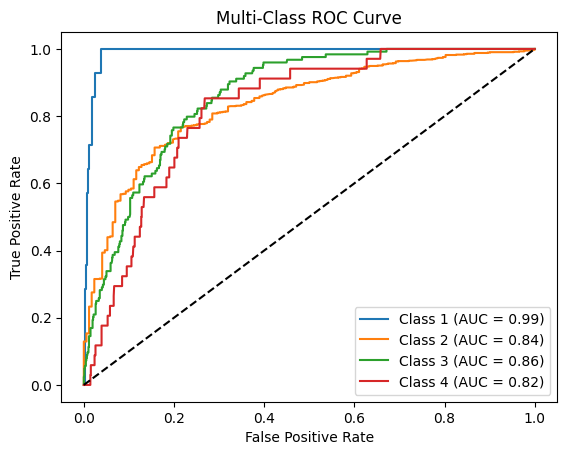

In [45]:
# Perform Recursive Feature Elimination (RFE)
selector = RFE(RandomForestClassifier(random_state=42), step=1)
selector.fit(X_train, y_train)

# Select only important features
X_train_selected = selector.transform(X_train)
X_validate_selected = selector.transform(X_validate)
X_test_selected = selector.transform(X_test)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [130, 170, 200],  
    'max_depth': [None, 5],  
    'min_samples_split': [1, 3, 7],  
    'ccp_alpha': [0, 0.001],  
    'max_samples': [None, 0.2, 0.4]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the **selected feature** training data
grid_search.fit(X_train_selected, y_train)

# Get the best model from the grid search
best_model_second = grid_search.best_estimator_

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Make predictions using the best model on the validation set
y_pred_validate = best_model_second.predict(X_validate_selected)

# Evaluate
print("\nEvaluate (Validation Set):")
evaluate(y_pred_validate, y_validate, X_validate_selected, best_model_second)



{'ccp_alpha': 0, 'max_depth': None, 'max_samples': None, 'min_samples_split': 3, 'n_estimators': 170}

In [ ]:
# # Perform Recursive Feature Elimination (RFE)
# selector = RFE(RandomForestClassifier(random_state=42), step=1)
# selector.fit(X_train, y_train)

# # Select only important features
# X_train_selected = selector.transform(X_train)
# X_validate_selected = selector.transform(X_validate)
# X_test_selected = selector.transform(X_test)

# # Define the parameter grid for tuning
# param_grid = {
#     'n_estimators': [50, 100, 150],  
#     'criterion': ["gini", "entropy", "log_loss"],  
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'min_weight_fraction_leaf': [0.0, 0.1, 0.2],  
#     'max_features': [None, 'sqrt', 'log2'],  
#     'max_leaf_nodes': [None, 10, 20, 50],  
#     'min_impurity_decrease': [0.0, 0.01, 0.1],  
#     'bootstrap': [True],  
#     'oob_score': [True],  # Only valid when bootstrap=True  
#     'warm_start': [True, False],  
#     'ccp_alpha': [0.0, 0.01, 0.1],  
#     'max_samples': [None, 0.5, 0.8]  
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_grid=param_grid,
#     cv=5,
#     n_jobs=-1,
#     verbose=2
# )

# # Fit the grid search to the **selected feature** training data
# grid_search.fit(X_train_selected, y_train)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

# # Print the best parameters found
# print("Best parameters found: ", grid_search.best_params_)

# # Make predictions using the best model on the validation set
# y_pred_validate = best_model.predict(X_validate_selected)

# # Evaluate
# print("\nEvaluate (Validation Set):")
# evaluate(y_pred_validate, y_validate, X_validate_selected, best_model)



Evaluate (Test Set):
Accuracy: 0.512
F1 Score: 0.6039816104692253
Classification Report:
               precision    recall  f1-score   support

           1       0.11      1.00      0.20         6
           2       0.97      0.48      0.64       857
           3       0.33      0.71      0.45       119
           4       0.05      0.72      0.09        18

    accuracy                           0.51      1000
   macro avg       0.36      0.73      0.34      1000
weighted avg       0.87      0.51      0.60      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 36 408 172 241]
 [ 11  10  85  13]
 [  1   2   2  13]]


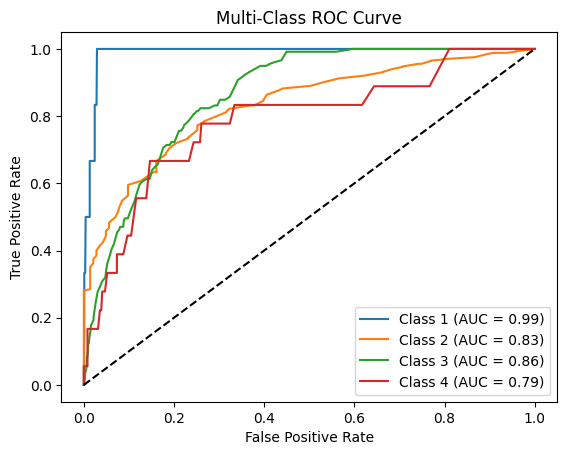

In [44]:

# Predict on the test set using the best model
y_pred_test = best_model.predict(X_test_selected)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test, y_test, X_test_selected, best_model)


Evaluate (Test Set):
Accuracy: 0.522
F1 Score: 0.6144419635146866
Classification Report:
               precision    recall  f1-score   support

           1       0.12      1.00      0.21         6
           2       0.97      0.49      0.65       857
           3       0.32      0.70      0.44       119
           4       0.05      0.67      0.09        18

    accuracy                           0.52      1000
   macro avg       0.36      0.71      0.35      1000
weighted avg       0.87      0.52      0.61      1000

Confusion Matrix:
 [[  6   0   0   0]
 [ 33 421 171 232]
 [ 11  10  83  15]
 [  1   3   2  12]]


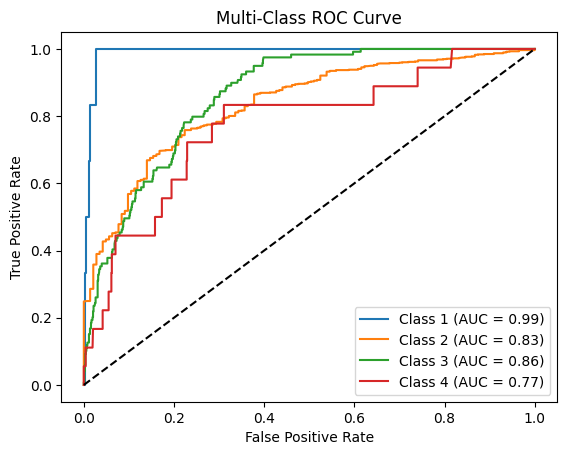

In [46]:

# Predict on the test set using the best model
y_pred_test = best_model_second.predict(X_test_selected)

# Evaluate
print("\nEvaluate (Test Set):")
evaluate(y_pred_test, y_test, X_test_selected, best_model_second)